For this project I will use [this kaggle dataset](https://www.kaggle.com/datasets/borismarjanovic/price-volume-data-for-all-us-stocks-etfs), which contains historic daily OHLC data for various securities. So to start we will download this dataset from kaggle. 

The dataset contains many different securities, to narrow it down im just gonna use this list of various historic S&P 500 stocks that I got from a university course.

In [1]:
import pandas as pd
import numpy as np

tickers = pd.read_csv('SP Tickers.csv')


In [2]:
tickers.head()

,symbol
0,A
1,AAL
2,AAP
3,AAPL
4,ABBV


In [3]:
tickers = set(tickers['symbol'].tolist())
len(tickers)

773

Currently all the different ticker data is in its own files, so we can load them all individually and combine them into one giant dataframe `stock_df`

In [4]:
import data_preparation
stock_df = data_preparation.load_df(tickers)

The next step is to create some more interesting features and partition the dataset into training and testing periods. Lets first understand what years the dataset has data for so we can define our training and backtest timeframes.

c:\Users\dylan\Documents\TradingStrategies\plotting.py:20: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Year', y='Count', data=rows_per_year, palette='viridis')


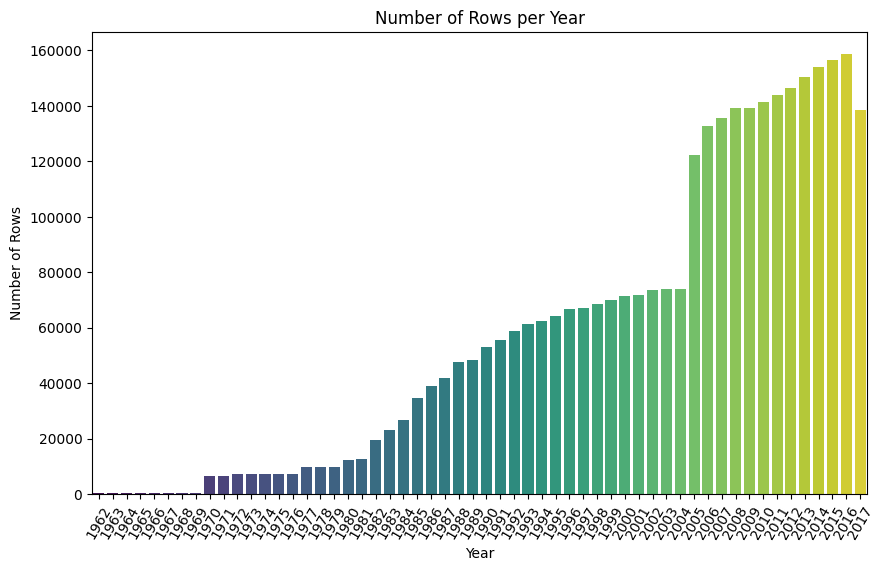

In [5]:
import plotting
plotting.plot_entries_per_year(stock_df)

We can see that there is a lot of data from 2005-2017. For the training set we will use 2010-2012 and for backtesting we will use 2013-2017.

In [6]:
TRAINING_START_DATE = pd.to_datetime("2010-01-01")
TRAINING_END_DATE = pd.to_datetime("2012-12-31")

BACKTEST_START_DATE = pd.to_datetime("2013-01-01")
BACKTEST_END_DATE = pd.to_datetime("2017-12-31")

Now lets train some models.

In [7]:
X_train, X_test, y_train, y_test = data_preparation.get_train_test(stock_df, tickers, TRAINING_START_DATE, TRAINING_END_DATE)

#### Random Forest

In [8]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import data_preparation

random_forest_clf = RandomForestClassifier(n_estimators=100, max_leaf_nodes=32, n_jobs=-1, bootstrap=True)
random_forest_clf.fit(X_train, y_train)
y_pred = random_forest_clf.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

        -1.0       0.58      0.14      0.23     37501
         1.0       0.52      0.90      0.66     39384

    accuracy                           0.53     76885
   macro avg       0.55      0.52      0.45     76885
weighted avg       0.55      0.53      0.45     76885



#### Gradient Boosting

In [9]:
from sklearn.ensemble import HistGradientBoostingClassifier

boosting_clf = HistGradientBoostingClassifier(max_leaf_nodes=32, learning_rate=0.2)
boosting_clf.fit(X_train, y_train)

y_pred = boosting_clf.predict(X_test)

print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

        -1.0       0.56      0.37      0.45     37501
         1.0       0.55      0.72      0.62     39384

    accuracy                           0.55     76885
   macro avg       0.55      0.55      0.53     76885
weighted avg       0.55      0.55      0.54     76885



### Strategy Implementation and Backtest

First we need to create a backtest dataframe with data to feed to the model for the whole backtest

In [10]:
backtest_df = data_preparation.get_features_df(stock_df, tickers, BACKTEST_START_DATE, BACKTEST_END_DATE, mode='backtest')

In [11]:
from strategies import MLModelStrategy, TrendCrossoverStrategy, VolatilityCondition
from backtest import gen_trades, compute_daily_returns, compute_metrics
from plotting import plot_comparative_returns, print_comparative_metrics, plot_entries_per_year
results = {}

rf_strategy = MLModelStrategy('Random Forest', random_forest_clf, data_preparation.get_features(backtest_df.head()))
boosting_strategy = MLModelStrategy('Gradient Boosting', boosting_clf, data_preparation.get_features(backtest_df.head()))

strategies = [rf_strategy, boosting_strategy]

conditions = [VolatilityCondition()]
additional_strategies = [TrendCrossoverStrategy()]

for ml_strategy in strategies:
    
    trades_df = gen_trades(backtest_df, ml_strategy, conditions, additional_strategies)        
    dates, daily_returns, cumulative_returns, portfolio_values, num_trades, num_longs, num_shorts, num_long_wins, num_short_wins = compute_daily_returns(trades_df)
        
    metrics = compute_metrics(dates, daily_returns, cumulative_returns, num_trades, num_longs, num_shorts, num_long_wins, num_short_wins)
        
    results[ml_strategy.name] = {
        'dates': dates,
        'daily_returns': daily_returns,
        'cumulative_returns': cumulative_returns,
        'portfolio_values': portfolio_values,
        'metrics': metrics
    }

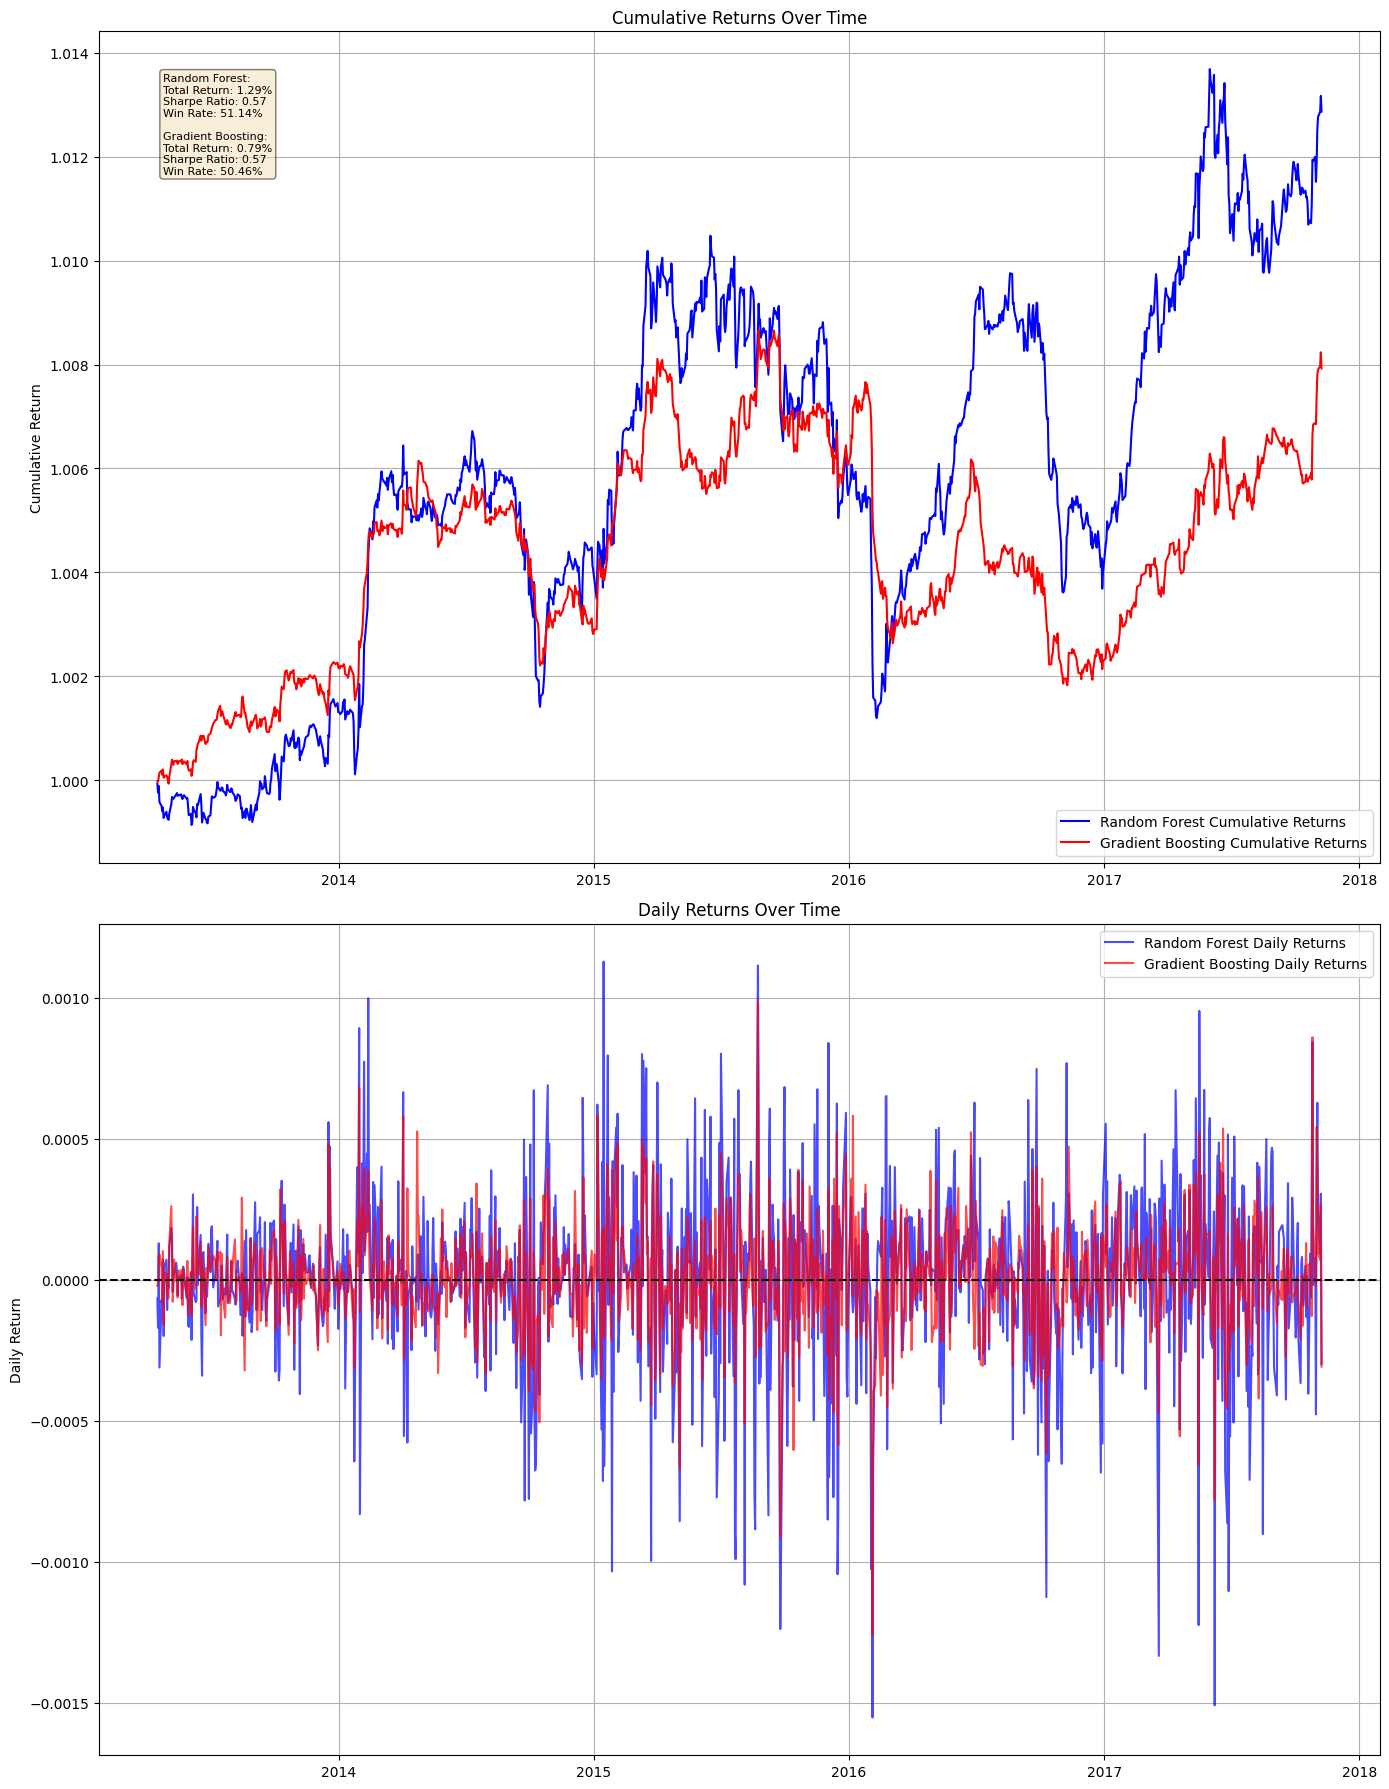


Metrics for Random Forest:
Total Return: 0.0129
Sharpe Ratio: 0.5731
Best Day: 0.0011
Worst Day: -0.0016
Number of Trades: 39800
Win Rate: 0.5114
Long Win Rate: 0.5155
Short Win Rate: 0.4891

Metrics for Gradient Boosting:
Total Return: 0.0079
Sharpe Ratio: 0.5724
Best Day: 0.0010
Worst Day: -0.0013
Number of Trades: 33631
Win Rate: 0.5046
Long Win Rate: 0.5193
Short Win Rate: 0.4796


In [12]:
plot_comparative_returns(results)
print_comparative_metrics(results)

In [13]:
for ml_strategy in strategies:
    
    trades_df = gen_trades(backtest_df, ml_strategy, conditions, additional_strategies, disable_shorting=True)        
    dates, daily_returns, cumulative_returns, portfolio_values, num_trades, num_longs, num_shorts, num_long_wins, num_short_wins = compute_daily_returns(trades_df)
        
    metrics = compute_metrics(dates, daily_returns, cumulative_returns, num_trades, num_longs, num_shorts, num_long_wins, num_short_wins)
        
    results[ml_strategy.name] = {
        'dates': dates,
        'daily_returns': daily_returns,
        'cumulative_returns': cumulative_returns,
        'portfolio_values': portfolio_values,
        'metrics': metrics
    }

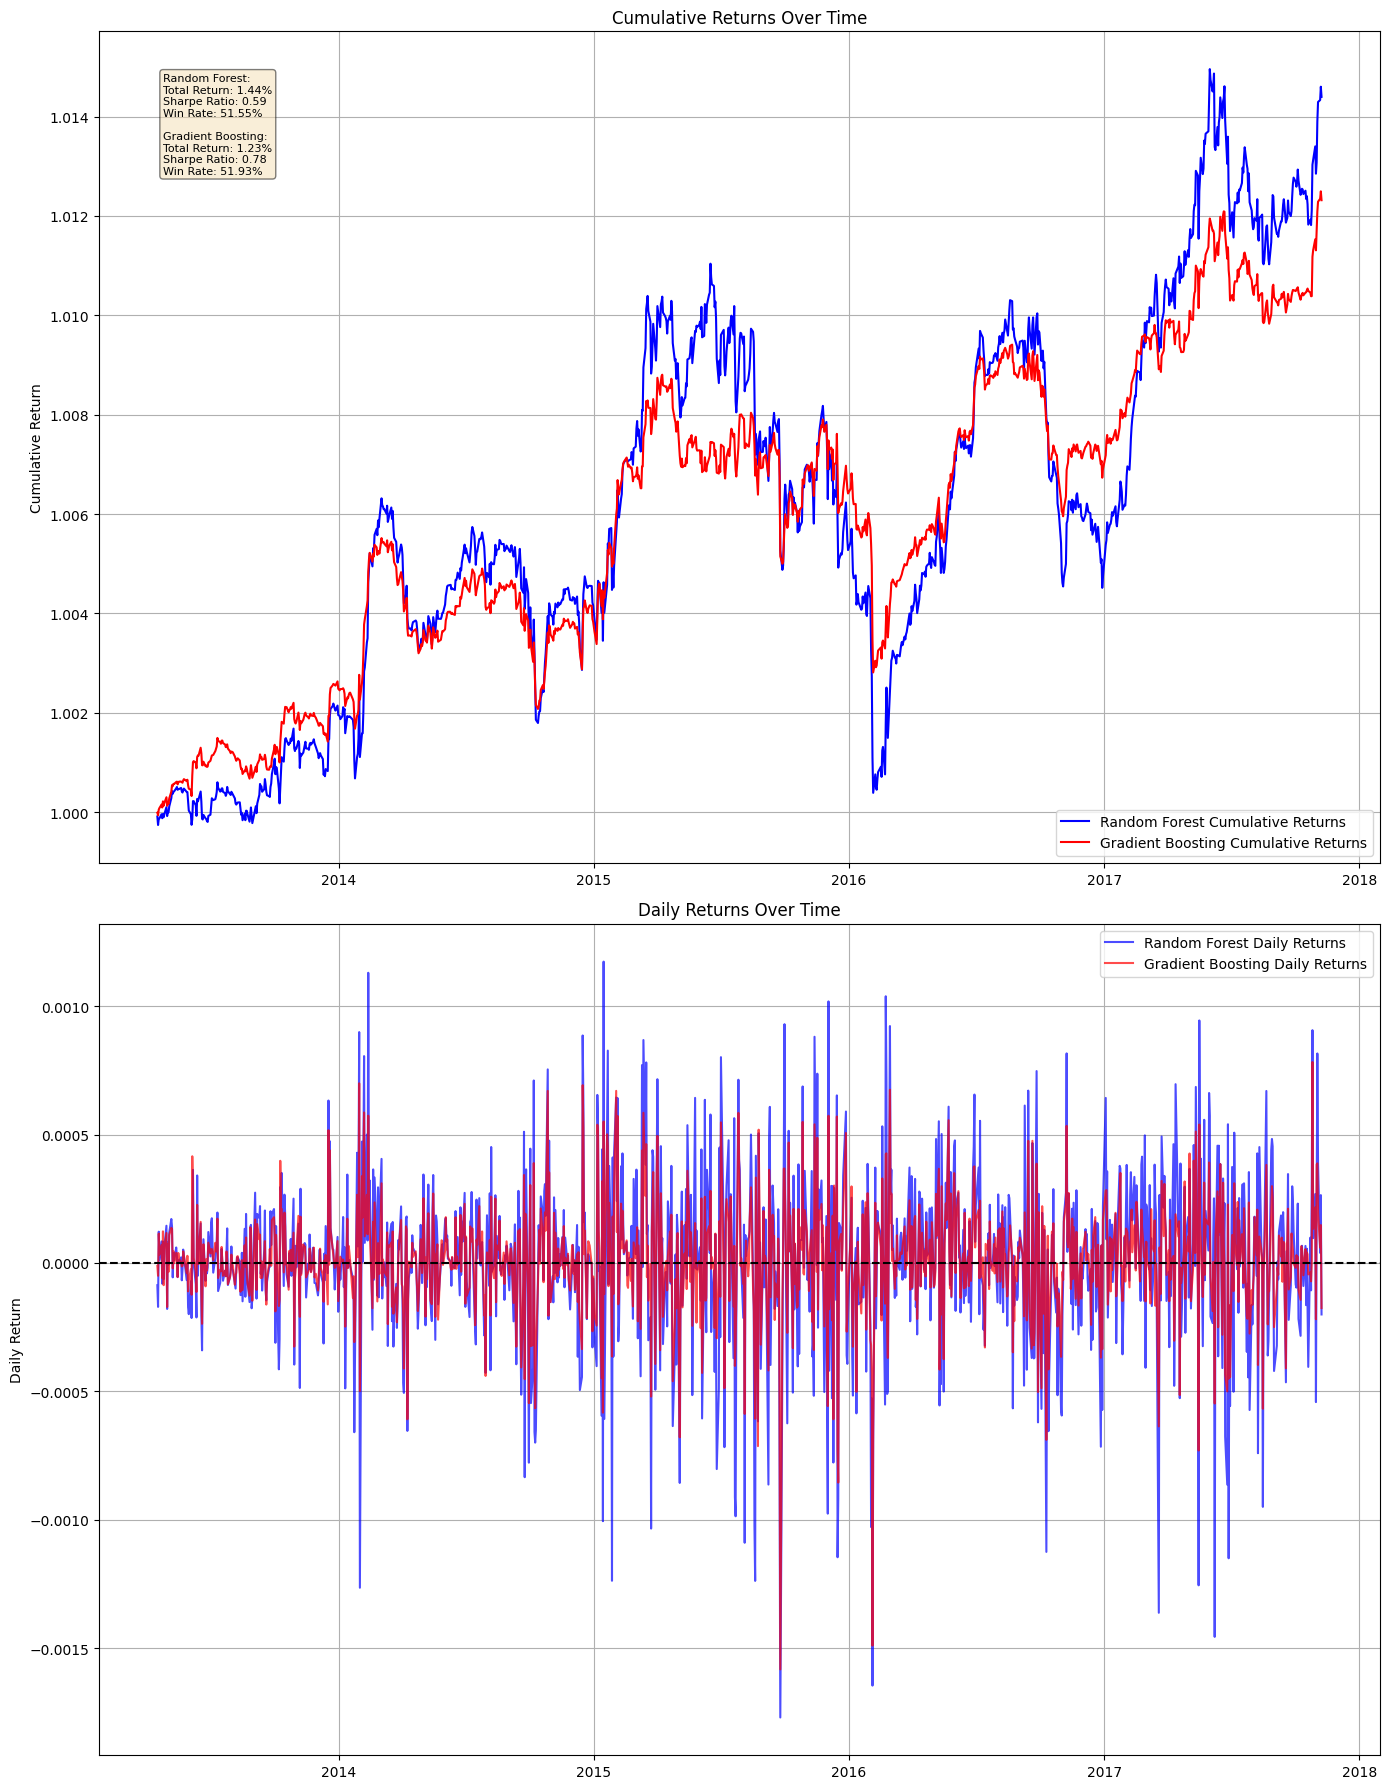


Metrics for Random Forest:
Total Return: 0.0144
Sharpe Ratio: 0.5922
Best Day: 0.0012
Worst Day: -0.0018
Number of Trades: 33628
Win Rate: 0.5155
Long Win Rate: 0.5155
Short Win Rate: 0

Metrics for Gradient Boosting:
Total Return: 0.0123
Sharpe Ratio: 0.7841
Best Day: 0.0008
Worst Day: -0.0016
Number of Trades: 21149
Win Rate: 0.5193
Long Win Rate: 0.5193
Short Win Rate: 0


In [14]:
plot_comparative_returns(results)
print_comparative_metrics(results)